# Prediction check ins on facebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft, rfft
from pandas.tools.plotting import autocorrelation_plot

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


## Load and examine data

In [3]:
dataurl = '/home/dbricare/Documents/Python/datasets/facebookV/'
dataparams = {'sep':',', 'compression':'zip'}

def inspectdata(testortrain):
    df = pd.read_csv(dataurl+testortrain+'.csv.zip', **dataparams)
    print(df.shape)
    dictcols = dict(zip(list(df.columns),[df[col].dtype for col in df.columns]))
    print(dictcols)
    return df

In [12]:
dftrain = inspectdata('train')
dftrain.head()

(29118021, 6)
{'x': dtype('float64'), 'time': dtype('int64'), 'y': dtype('float64'), 'place_id': dtype('int64'), 'accuracy': dtype('int64'), 'row_id': dtype('int64')}


,row_id,x,y,accuracy,time,place_id
0,0,0.7941,9.0809,54,470702,8523065625
1,1,5.9567,4.7968,13,186555,1757726713
2,2,8.3078,7.0407,74,322648,1137537235
3,3,7.3665,2.5165,65,704587,6567393236
4,4,4.0961,1.1307,31,472130,7440663949


In [5]:
dftest = inspectdata('test')
dftest.head()

(8607230, 5)
{'x': dtype('float64'), 'time': dtype('int64'), 'y': dtype('float64'), 'accuracy': dtype('int64'), 'row_id': dtype('int64')}


,row_id,x,y,accuracy,time
0,0,0.1675,1.3608,107,930883
1,1,7.3909,2.5301,35,893017
2,2,8.0978,2.3473,62,976933
3,3,0.9990,1.0591,62,907285
4,4,0.6670,9.7254,40,914399


### Examination of output variable `place_id`

In [7]:
print('Number of unique place_id values:', len(dftrain['place_id'].unique()))

Number of unique place_id values: 108390


In [18]:
print(dftrain['place_id'].min(), dftrain['place_id'].max())

1000015801 9999932225


### Interpretation of time

All of the test data occur chronologically after training data. Humans have intrinsic seasonal or temporal patterns to their behavior, so it makes sense to look for these patterns in the `time` feature and use them to predict the `place_id`.

First begin by searching for potential units for the time data.

Can multiple events occur at each timestamp?

In [25]:
print('Unique timestamps:', len(dftrain['time'].unique()))
print('Total events:', len(dftrain))

Unique timestamps: 786239
Total events: 29118021


Yes, multiple events can occur at each time stamp.

In [20]:
dftrain['time'].describe()

count    2.911802e+07
mean     4.170104e+05
std      2.311761e+05
min      1.000000e+00
25%      2.030570e+05
50%      4.339220e+05
75%      6.204910e+05
max      7.862390e+05
Name: time, dtype: float64

In [21]:
dftest['time'].describe()

count    8.607230e+06
mean     8.904637e+05
std      6.446783e+04
min      7.862420e+05
25%      8.332200e+05
50%      8.874620e+05
75%      9.454910e+05
max      1.006589e+06
Name: time, dtype: float64

So training data ranges from time=1 to time=786239. This is likely a counter. What is the most reasonable unit for the time counter?

In [60]:
def timerange(df):
    rng = df['time'].max() - df['time'].min()
    print('days in years:', rng/365)
    print('hours in years:', rng/(365*24))
    print('minutes in years:', rng/(365*24*60))
    print('seconds in days:', rng/(24*60*60))
    return

In [61]:
timerange(dftrain)

days in years: 2154.07671233
hours in years: 89.753196347
minutes in years: 1.49588660578
seconds in days: 9.09997685185


For the test data time range,

In [62]:
timerange(dftest)

days in years: 603.690410959
hours in years: 25.1537671233
minutes in years: 0.419229452055
seconds in days: 2.5503125


Seems difficult to determine but most likely interpretation is minutes or seconds. Facebook is a large organization so it is possible for them to collect data on one hundred thousand places in about 9 days for seconds or 1.5 years for minutes. If the time range is hours or longer, it would be impossible to collect data over this time range.

However the time column could be an arbitrary unit of time composed of some fraction of seconds and minutes.

What does the seasonality look like if data is in minutes?

111
0    14.828472
1    42.879861
2    58.952778
3    39.337500
4    91.196528
Name: time, dtype: float64


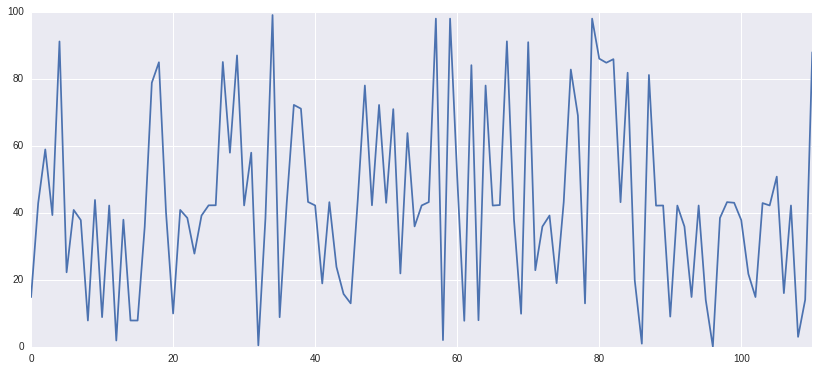

In [9]:
serdays = dftrain['time'][dftrain['place_id']==dftrain['place_id'].iloc[10]]/(24*60)
serdays.reset_index(drop=True, inplace=True)
print(len(serdays))
if len(serdays)<100:
    print(serdays)
else:
    print(serdays.head())
_ = serdays.plot(figsize=(14,6))

count    111.000000
mean      43.223586
std       27.196385
min        0.023611
25%       20.845833
50%       42.207639
75%       58.469097
max       99.090972
Name: time, dtype: float64

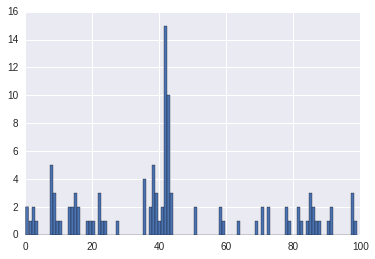

In [13]:
_ = serdays.hist(bins=len(serdays.unique()))
serdays.describe()

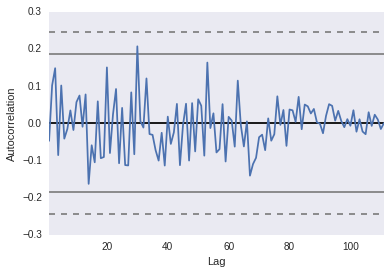

In [23]:
_ = autocorrelation_plot(serdays)
_ = plt.ylim(-.3,.3)

What does the variation in timestamps like if minutes are assumed?

In [5]:
# sermins = dftrain['time'].sample(n=100000)/(24*60)
sermins = dftrain['time']/(24*60)
# sermins = sermins.astype(int)

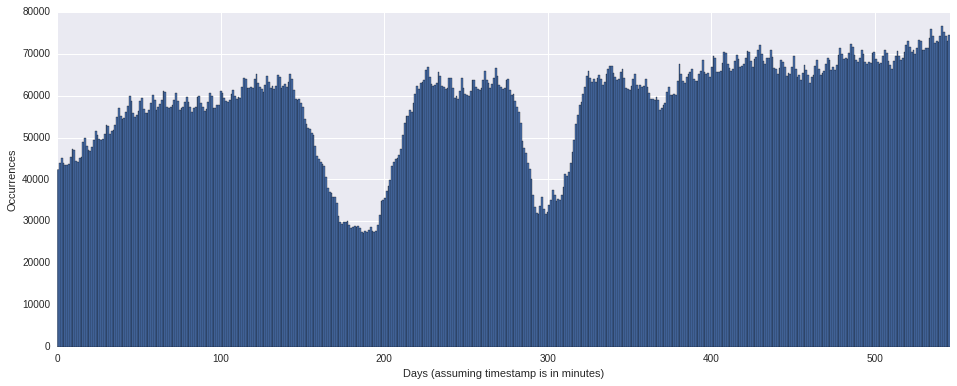

In [72]:
_ = sermins.hist(bins=500, figsize=(16,6))
_ = plt.xlim(0,sermins.max())
_ = plt.xlabel('Days (assuming timestamp is in minutes)')
_ = plt.ylabel('Occurrences')

Appears to be two distinct time-varying structures here. Two prominent dips in low frequency signal. Very regular variation in high frequency signal.

What does fast Fourier transform show?

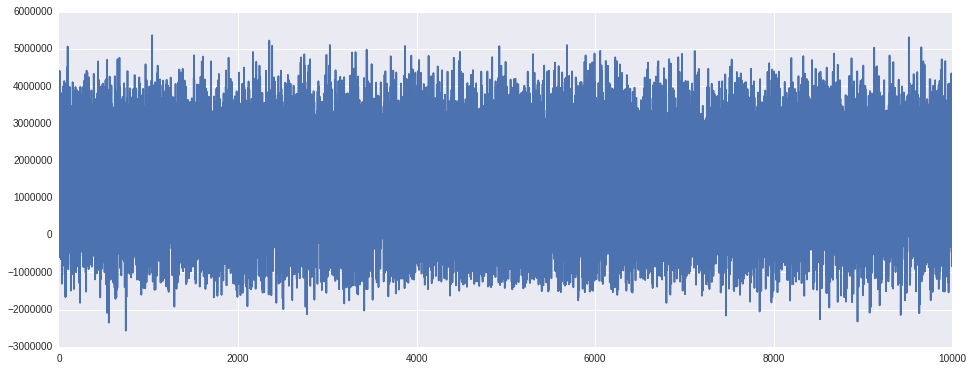

In [74]:
serfft = pd.Series(rfft(sermins, n=10000))
_ = serfft.iloc[1:].plot(figsize=(16,6))

## Simple kNearestNeighbors based on location

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knnc = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', n_jobs=4)
knnc.fit(dftrain[['x', 'y']], dftrain['place_id'])

To make predictions, must divide test data into chunks in order to prevent memory overflow.

In [13]:
testiter = pd.read_csv(dataurl+'test.csv.zip', usecols=['row_id','x','y'], iterator=True, chunksize=5000, **dataparams)

In [14]:
# save each chunk to disk as a csv and append new chunks to save memory
cols = sorted(dftrain['place_id'].unique().tolist())
dftrain = None

counter = 0
# chunk = testiter.get_chunk()
for chunk in testiter:
    dfprobs = pd.DataFrame(knnc.predict_proba(chunk[['x','y']]), columns=cols)
    ypred = []
    for row in dfprobs.index:
        ypred.append(' '.join([str(i) for i in dfprobs.iloc[row].sort_values(ascending=False).index[:3]]))
    dfpred = pd.DataFrame(ypred, index=chunk['row_id'], columns=['place_id'])
    if counter==0:
        header=True
        counter+=1
    else:
        header=False
    dfpred.to_csv('fb.csv', mode='a', header=header)

    
    # for chunk in testiter:
#     dfprobs = pd.DataFrame(knnc.predict_proba(chunk[['x','y']]), columns=cols)
#     ypred = []
#     for row in dfprobs.index:
#         ypred.append(dfprobs.iloc[row].sort_values(ascending=False).index[:3])
#     dfpred = pd.DataFrame(ypred)
#     dfpred

MemoryError: 